In [0]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
%matplotlib inline
sns.set()

In [2]:
#Regular dataset for the country
dfc = pd.read_csv("ukTrafficAADF.csv")
#Dataset based off regions with income, due to missing data, there are less roads (data) than in country
dfi = pd.read_csv("AADF data with income and population.csv")
df = dfi
df.drop(columns='Unnamed: 0', inplace=True)
df.head()

FileNotFoundError: ignored

# How can we understand trends within Transportation?

Even though the core data was about accidents, having solid metrics on the various modes of transportation could help us understand their trends, and perhaps even if we could predict them. For this project, we will look at specifically 'Bike Trends'.

This could help city officials to predict where they should be investing in infrastructure to build more bike lanes, store owners where to set up potentials stores, and sociologists to understand the relationship between how we live with how we get around.

We want to look at two core questions:

#### 1) Does income affect bike trends - and if so - positively or negatively?

#### 2) Does traffic flow affect bike trends?


## Introductory Analysis
We will start by visualising overall, over the years, how the trends have been shifting.

Because there are so many more cars/taxis than any other medium, we took the log-value.
As we can see, Cars/Taxis are pretty consistent with a slight dip in the last few years, while the biggest shift has been with bikes.

       CarsTaxis  PedalCycles  Motorcycles  BusesCoaches
count  17.000000    17.000000    17.000000     17.000000
mean   18.726171    14.041572    14.545026     14.749709
std     0.010315     0.192446     0.096579      0.020284
min    18.706849    13.713419    14.402553     14.710809
25%    18.717461    13.891808    14.450009     14.735883
50%    18.725781    14.108183    14.553075     14.752401
75%    18.731338    14.157262    14.616299     14.762290
max    18.743707    14.407660    14.702187     14.786092


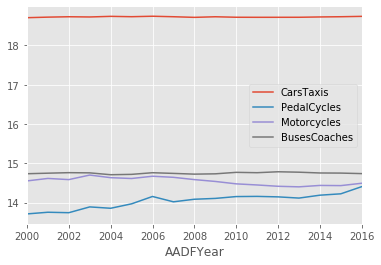

In [0]:
transporttrends = np.log(df.groupby("AADFYear").sum()[['CarsTaxis','PedalCycles','Motorcycles','BusesCoaches']])
years = pd.to_numeric(df["AADFYear"]).unique()

print(transporttrends.describe())

transporttrends.plot();

### 1) Does income affect bike trends - and if so - positively or negatively?

To start, let us look at finanicial trends:

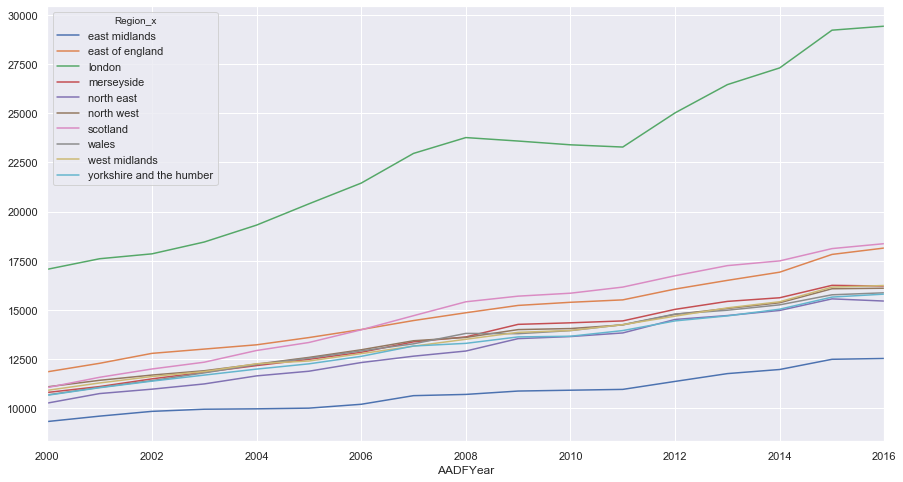

In [0]:
income = df.groupby(["AADFYear","Region_x","LocalAuthority"])["Gross Disposable Household Income"].mean().reset_index()
financetrends = income.groupby(["AADFYear","Region_x"])["Gross Disposable Household Income"].mean().unstack("Region_x")
financetrends.plot(figsize=(15,8));

As we can see, there seems to be a consistent trend of increase of Wealth by region, whereas with London the increase in much more significant. 

In order to see how the trend of income affects transportation, we will look into London, and see which trends arose.

0.7869215616084423


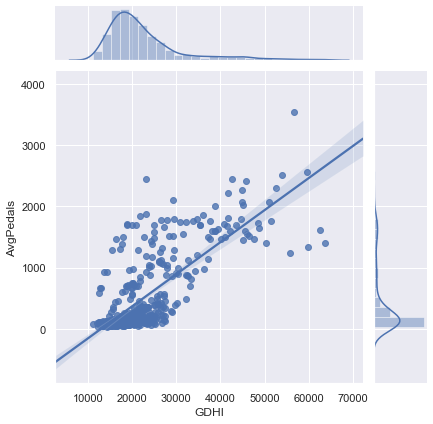

In [0]:
# Create two DF's which provide the mean income/pedal cycles for each Local Authroity per Year

ldnincome = income.loc[(income["Region_x"]=="london")].groupby(["AADFYear","LocalAuthority"])["Gross Disposable Household Income"].mean().unstack("LocalAuthority")
ldncycles = df.loc[df["Region_x"]=="london"].groupby(["AADFYear","LocalAuthority"])["PedalCycles"].mean().unstack("LocalAuthority")

#Calculate their Correlation
print(ldnincome.corrwith(ldncycles, axis =1).mean())

#Plot their Correlation
ldncombine = pd.concat([ldnincome.stack("LocalAuthority"),ldncycles.stack("LocalAuthority")],axis=1)
ldncombine.columns=["GDHI","AvgPedals"]

sns.jointplot("GDHI", "AvgPedals", data=ldncombine, kind='reg');


What we see here is a <b>very strong</b> correlation between a Neighborhood's GDHI and its average number of Cyclists - .78 Correlation!

It would be tempting to think that families with larger incomes tend to lead to more cyclists, but because people travel across Neighborhoods, all we have shown is a correlation between people traveling through a neighborhood and the neighborhood's relative income. Most likely, a wealtheir neighborhood attracts more business and becomes a hub of transport, thereby causing more pedalists.

Does this correlation hold, when we look at cyclists as a percentage of total traffic?


0.7007672161107938


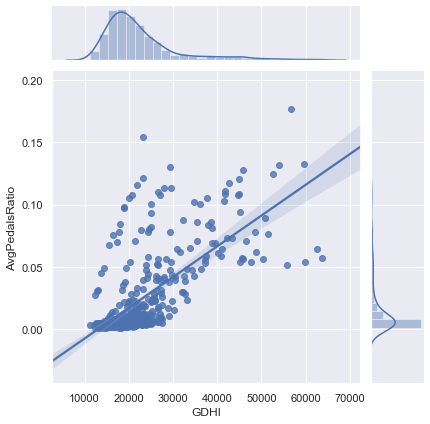

In [0]:
transporttrends = df.loc[df["Region_x"] == "london"].groupby(["AADFYear","LocalAuthority"]).sum()[['CarsTaxis','PedalCycles','Motorcycles','BusesCoaches']]/1000
transporttrends['total'] = transporttrends.sum(axis=1)
transporttrends['AvgPedals'] = transporttrends["PedalCycles"] / transporttrends["total"]
ldncyclesratio = transporttrends['AvgPedals'].unstack("LocalAuthority")

#Now we can check the correlation as we did before:

#Calculate their Correlation
print(ldnincome.corrwith(ldncyclesratio, axis =1).mean())


#Plot their Correlation
ldncombine2 = pd.concat([ldnincome.stack("LocalAuthority"),ldncyclesratio.stack("LocalAuthority")],axis=1)
ldncombine2.columns=["GDHI","AvgPedalsRatio"]

sns.jointplot("GDHI", "AvgPedalsRatio", data=ldncombine2, kind='reg');

Even though the correlation is less, it is still <b>significant</b> with .7
We still haven't proven if the increase in cyclists is due to richer households themselves pedaling more, or richer neighborhoods attracting bicycles, but eitherway the data is clear - economic growth is clearly highly correlated with an increase in biking.

### 2) Does traffic congestion affect bike trends?

In [0]:
df = dfc
df_roads = df.groupby("RoadCategory")[['PedalCycles',"AllMotorVehicles"]].sum()
df_roads

,PedalCycles,AllMotorVehicles
RoadCategory,,
PM,114,34718944
PR,2125145,1014735119
PU,31208775,2661134537
Pu,291,128220
TM,782,1190417527
TR,256672,720904546
TU,367025,203047723
Tu,202,47895


We can see here that we need to clean out data and turn Tu -> TU and Pu -> PU

In [0]:
df['RoadCategory'] = df['RoadCategory'].str.upper()
df_roads = df.groupby("RoadCategory")[['PedalCycles',"AllMotorVehicles"]].sum()
df_roads

,PedalCycles,AllMotorVehicles
RoadCategory,,
PM,114,34718944
PR,2125145,1014735119
PU,31209066,2661262757
TM,782,1190417527
TR,256672,720904546
TU,367227,203095618


C:\Users\shaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:20: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.


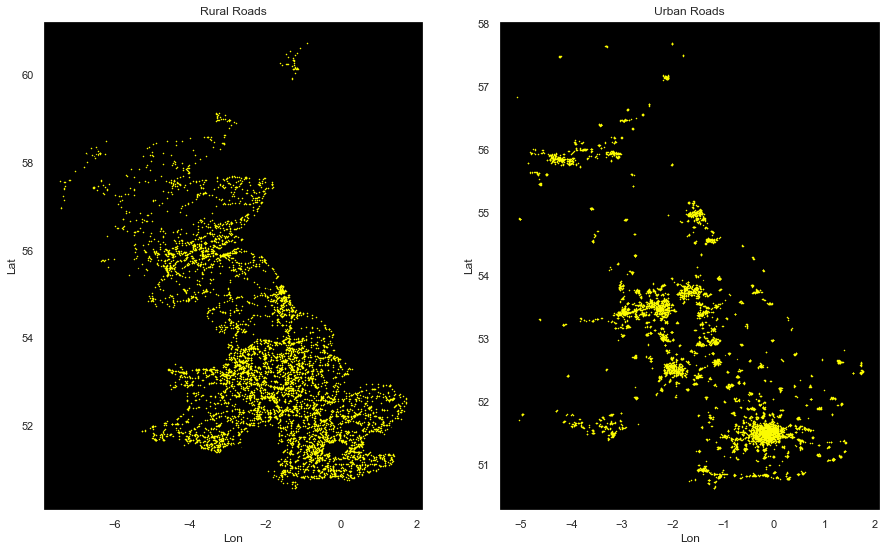

In [0]:
Rural = df[(df["RoadCategory"] == "PR") | (df["RoadCategory"] == "TR")]
Urban = df[(df["RoadCategory"] == "PU") | (df["RoadCategory"] == "TU")]

f, (ax1,ax2) = plt.subplots(1,2,figsize=(15,9))

Rural.plot(kind='scatter', x='Lon',y ='Lat',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax1)
ax1.grid(False)
ax1.set_title("Rural Roads")
ax1.set_facecolor('black')

Urban.plot(kind='scatter', x='Lon',y ='Lat',
                color='yellow', 
                s=.02, alpha=.6, subplots=True, ax=ax2)
ax2.grid(False)
ax2.set_title("Urban Roads")
ax2.set_facecolor('black')

f.show()

In [0]:
Rural['BikeRatio'] = Rural['PedalCycles'] / Rural['AllMotorVehicles'] * 100
ruraltrends = Rural.groupby(['AADFYear','Region'])['BikeRatio'].mean().unstack("Region")
ruraltrends.plot(figsize=(12,8))

Looking at the images, we can see that if we want to explore how congestion of roads affect traffic, the important element to focus on would be Urban Roads, as they express transportation within cities.

C:\Users\shaul\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


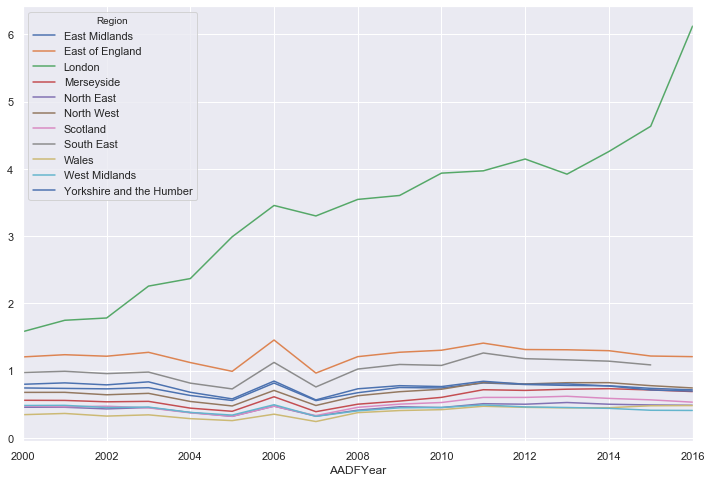

In [0]:
Urban['BikeRatio'] = Urban['PedalCycles'] / Urban['AllMotorVehicles'] * 100
urbantrends = Urban.groupby(['AADFYear','Region'])['BikeRatio'].mean().unstack("Region")
urbantrends.plot(figsize=(12,8))

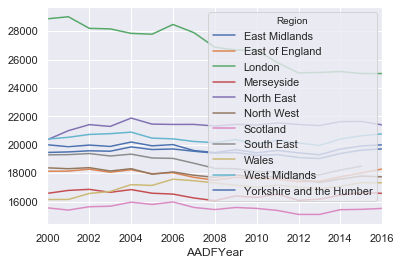

In [0]:
urbantraf = Urban.groupby(['AADFYear','Region'])['AllMotorVehicles'].mean().unstack("Region")
urbantraf.plot()